This notebook was used to collect data (apart from what we already had) which we used to infer labels using Vader
We already have a dataset to begin with but the accuracy wasn't right, even after trying sampling, and many other things, and in order to make sure that we weren't overfitting to the data, we decided to not only use an available dataset, but mine new data from the Reddit API for python for training.

In [1]:
from IPython import display
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#pprint means pretty print JSON and lists

from pprint import pprint 

import nltk
sns.set(style='darkgrid', context='talk', palette='Dark2')

#importing libraries
!pip install praw
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\poorn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Getting reddit posts in real time
import praw
reddit = praw.Reddit(client_id='<Enter_Client_ID>',
                     client_secret='<Enter_Client_Secret_Code>',
                     user_agent='<Enter_user_agent_details>')
headlines = list()
for submission in reddit.subreddit('Politics').top(limit=10):
    #limit none means latest 100 headlines
    headlines.append(submission.title)
    display.clear_output()
    print(len(headlines))

10


In [3]:
headlines.sort()
# headlines

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

pprint(results[:3])

[{'compound': -0.0258,
  'headline': 'A petition calling for FCC Chairman Ajit Pai to resign is '
              'racking up huge numbers',
  'neg': 0.144,
  'neu': 0.719,
  'pos': 0.138},
 {'compound': -0.3612,
  'headline': 'California bans private prisons – including Ice detention '
              'centers',
  'neg': 0.263,
  'neu': 0.737,
  'pos': 0.0},
 {'compound': 0.0,
  'headline': 'F.B.I. Opened Inquiry Into Whether Trump Was Secretly Working '
              'on Behalf of Russia',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0}]


In [5]:
df = pd.DataFrame.from_records(results)

In [6]:
# compound show the sentiment value (-1(extremely negative) to +1(extremly positive))
df.head(4)

,compound,headline,neg,neu,pos
0,-0.0258,A petition calling for FCC Chairman Ajit Pai t...,0.144,0.719,0.138
1,-0.3612,California bans private prisons – including Ic...,0.263,0.737,0.000
2,0.0000,F.B.I. Opened Inquiry Into Whether Trump Was S...,0.000,1.000,0.000
3,0.0000,Ivanka Trump used a personal email account to ...,0.000,1.000,0.000


Here, we use the compound attribute from Vader to approximate the sentiment of each sentence.

In [7]:
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2 , 'label'] = -1
df.head()

,compound,headline,neg,neu,pos,label
0,-0.0258,A petition calling for FCC Chairman Ajit Pai t...,0.144,0.719,0.138,0
1,-0.3612,California bans private prisons – including Ic...,0.263,0.737,0.000,-1
2,0.0000,F.B.I. Opened Inquiry Into Whether Trump Was S...,0.000,1.000,0.000,0
3,0.0000,Ivanka Trump used a personal email account to ...,0.000,1.000,0.000,0
4,0.0000,Jon Stewart Goes Off On Congress During 9/11 H...,0.000,1.000,0.000,0


In [8]:
df2 = df[['headline','label']]
df2.to_csv('New_Data', mode='a' ,encoding = 'utf-8', index=False)
df2.to_parquet('NewData.parquet')

# Exploratory Data Analysis

In [9]:
print("Positive headlines:\n")
pprint(list(df[df['label'] == 0].headline)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(df[df['label'] == -1].headline)[:5], width=200)

Positive headlines:

['A petition calling for FCC Chairman Ajit Pai to resign is racking up huge numbers',
 'F.B.I. Opened Inquiry Into Whether Trump Was Secretly Working on Behalf of Russia',
 'Ivanka Trump used a personal email account to send hundreds of emails about government business last year',
 'Jon Stewart Goes Off On Congress During 9/11 Hearing',
 'Trump revealed highly classified information to Russian foreign minister and ambassador.']

Negative headlines:

['California bans private prisons – including Ice detention centers',
 'Kim Davis, clerk who refused to sign marriage licenses for gay couples, loses to Democrat',
 'McConnell blocks House bill to reopen government for second time',
 'The FCC’s craven net neutrality vote announcement makes no mention of the 22 million comments filed',
 'Trump Ordered Mueller Fired, but Backed Off When White House Counsel Threatened to Quit']


In [10]:
print(df.label.value_counts())
print(df.label.value_counts(normalize=True)*100) #shows percentage

-1    5
 0    5
Name: label, dtype: int64
-1    50.0
 0    50.0
Name: label, dtype: float64


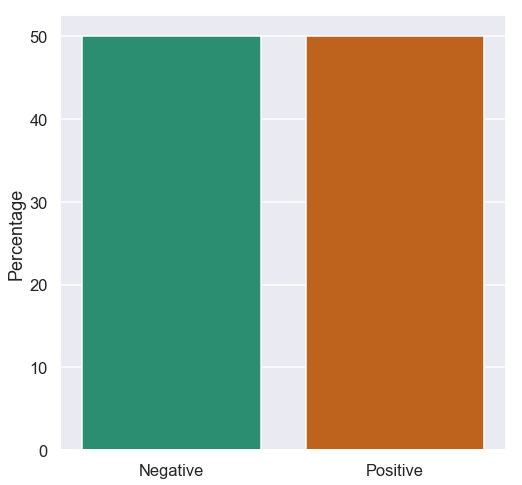

In [11]:
fig,ax = plt.subplots(figsize=(8,8));

counts = df.label.value_counts(normalize=True)*100

sns.barplot(x=counts.index, y=counts, ax=ax);
ax.set_ylabel('Percentage');
ax.set_xticklabels(['Negative','Positive'])
plt.show()


# Data Preprocess

In [12]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize,RegexpTokenizer
example = "This is a good example for how RegexpTokenizer Wow"

print(word_tokenize(example, language='english'))

tokenizer = RegexpTokenizer(r'\w+') #does not contain punctuation only consider workds
tokenizer.tokenize(example)

['This', 'is', 'a', 'good', 'example', 'for', 'how', 'RegexpTokenizer', 'Wow']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\poorn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['This', 'is', 'a', 'good', 'example', 'for', 'how', 'RegexpTokenizer', 'Wow']

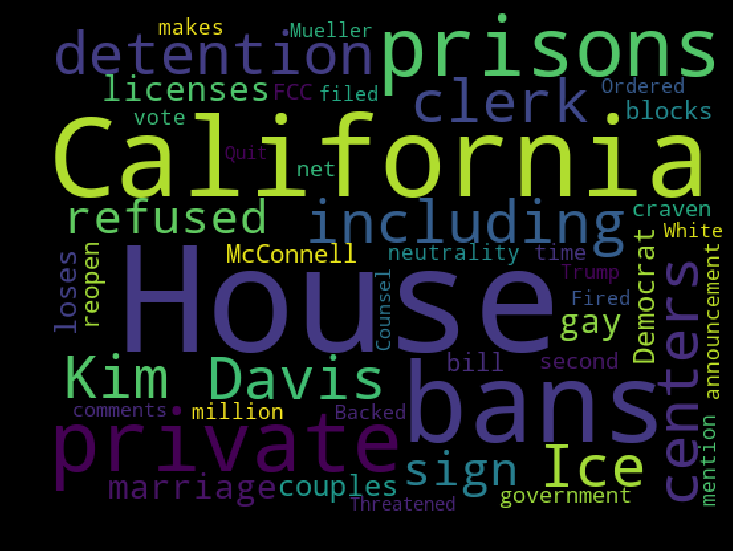

In [13]:
from wordcloud import WordCloud
non_bully_words = ' '.join(list(df[df['label'] == -1]['headline']))
non_bully_wc = WordCloud(width = 512,height = 380).generate(non_bully_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(non_bully_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

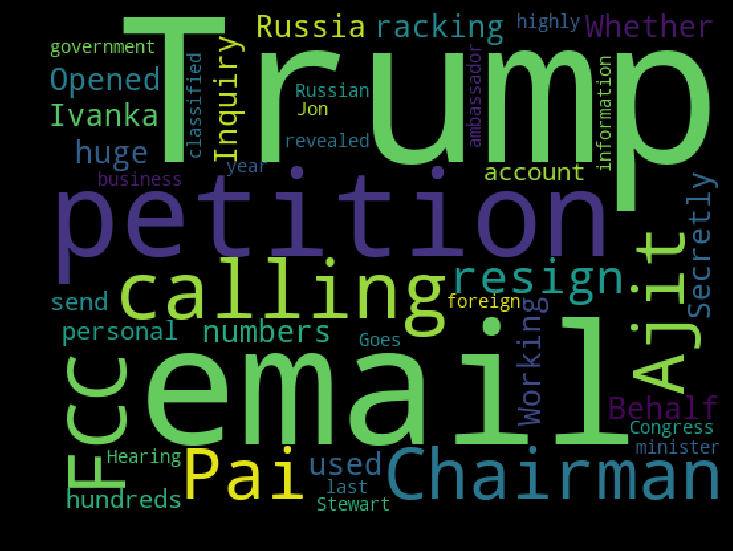

In [14]:
from wordcloud import WordCloud
non_bully_words = ' '.join(list(df[df['label'] == 0]['headline']))
non_bully_wc = WordCloud(width = 512,height = 380).generate(non_bully_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(non_bully_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [15]:
#removing stopwords like ’the, ’is’, ’and’, ’what’, etc. that are irrelevant to sentiment and dont provide any valuable information
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\poorn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Word Distribution
def process_text(headlines):
    tokens = []
    for line in headlines:
        token = tokenizer.tokenize(line)
        token = [t.lower() for t in token if t.lower() not in stop_words]
        tokens.extend(token)
    return tokens

In [17]:
pos_lines = list(df[df.label == 0].headline)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('trump', 3),
 ('petition', 1),
 ('calling', 1),
 ('fcc', 1),
 ('chairman', 1),
 ('ajit', 1),
 ('pai', 1),
 ('resign', 1),
 ('racking', 1),
 ('huge', 1),
 ('numbers', 1),
 ('f', 1),
 ('b', 1),
 ('opened', 1),
 ('inquiry', 1),
 ('whether', 1),
 ('secretly', 1),
 ('working', 1),
 ('behalf', 1),
 ('russia', 1)]

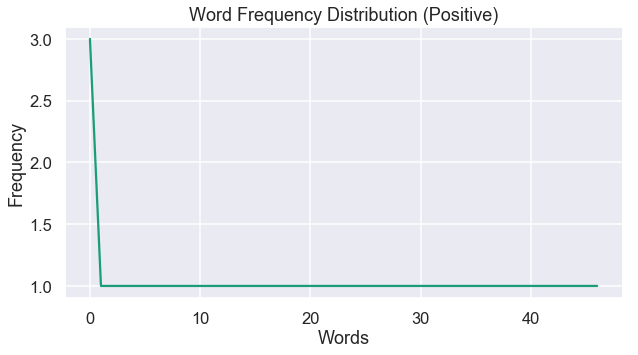

In [18]:
y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

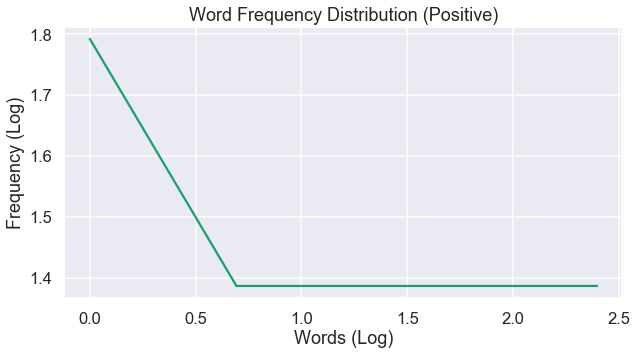

In [19]:
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

In [20]:
# negative words
neg_lines = list(df2[df2.label == 0].headline)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

[('trump', 3),
 ('petition', 1),
 ('calling', 1),
 ('fcc', 1),
 ('chairman', 1),
 ('ajit', 1),
 ('pai', 1),
 ('resign', 1),
 ('racking', 1),
 ('huge', 1),
 ('numbers', 1),
 ('f', 1),
 ('b', 1),
 ('opened', 1),
 ('inquiry', 1),
 ('whether', 1),
 ('secretly', 1),
 ('working', 1),
 ('behalf', 1),
 ('russia', 1)]

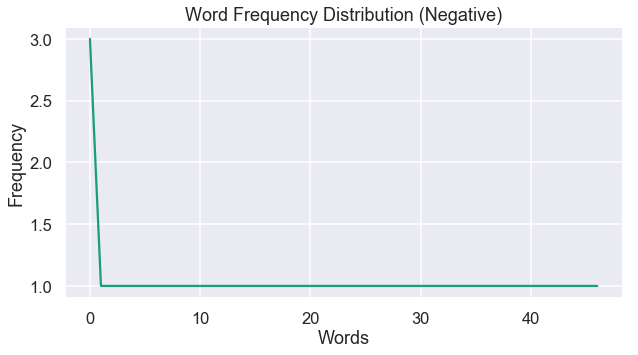

In [21]:
y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

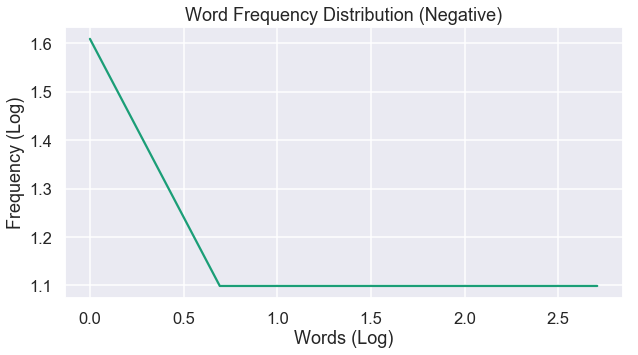

In [22]:
y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
    if i + k + z == 0:
        break
    y_final.append(math.log(i + k + z))

x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val, y_final)
plt.show()